In [1]:
import numpy as np
import torch
import timeit
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats

### Write a series of for loops that compute a average value in torch_tensor3d

In [2]:
def calc_avg_val_by_fors(t3d : torch.tensor) -> float:
    """
    calculate avg by iterating through a 3D tensor
    :param t3d: a 3D tensor
    :return: returns average value of a 3D tensor
    """
    sum = 0
    for tn in t3d:                  # iterate through all tensors
        for ti in tn:               # iterate each tensor
            for i in ti:            # iterate each tensor item
                sum += i.item()
    avg = sum / torch.numel(t3d)    # number of items in a tensor
    return avg


In [3]:
# our predifined tensor
torch_tensor3d = torch.tensor([
                                [
                                [ 1,  2,  3],
                                [ 4,  5,  6],
                                ],
                                [
                                [ 7,  8,  9],
                                [10, 11, 12],
                                ],
                                [
                                [13, 14, 15],
                                [16, 17, 18],
                                ],
                                [
                                [19, 20, 21],
                                [22, 23, 24],
                                ]
                              ])

In [4]:
avg_val_by_fors = calc_avg_val_by_fors(torch_tensor3d)
print("torch_tensor3d average with for-loops: "+str(avg_val_by_fors))

torch_tensor3d average with for-loops: 12.5


### Write code that indexes into torch_tensor3d and prints out the value 13.

In [5]:
torch_tensor3d[2,0,0].item()

13

### For every power of 2, create a random matrix.
Time how long it takes to compute XX on a CPU and on a GPU, and plot the speedup.
For what matrix sizes is the CPU faster than the GPU

<AxesSubplot: >

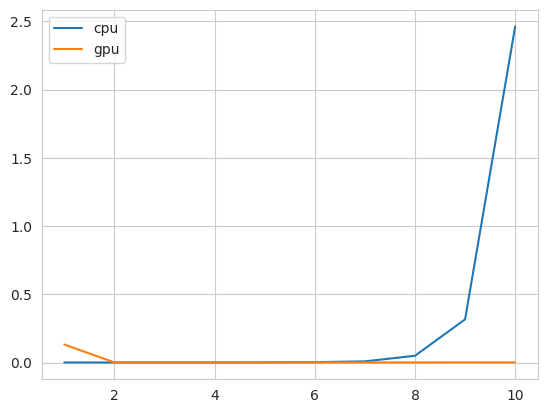

In [6]:
pof2 = []
cpu = []
gpu = []
for i in range(1, 11):
    c = torch.rand(2**i, 2**i, device=torch.device("cpu"))
    g = torch.rand(2**i, 2**i, device=torch.device("cuda"))
    time_cpu = timeit.timeit("c@c", globals=globals(), number=100)
    time_gpu = timeit.timeit("g@g", globals=globals(), number=100)
    pof2.append(i)
    cpu.append(time_cpu)
    gpu.append(time_gpu)

sns.lineplot(x=pof2, y=cpu, label="cpu")
sns.lineplot(x=pof2, y=gpu, label="gpu")

### We used PyTorch to find the numeric solution to $f(x) = (x−2)^2$
Write code that finds the solution to $f(x) = sin(x − 2) * (x + 2)^2 + √|cos(x)|$.
What answer do you get?

In [7]:
def f(x):
    a = torch.sin(x-2.0)
    b = torch.pow(x+2, 2)
    c = torch.cos(x)
    return torch.add(torch.mul(a, b), torch.sqrt(torch.abs(c)))

x_param = torch.nn.Parameter(torch.tensor([-3.0]), requires_grad=True)
eta = 0.1
optimizer = torch.optim.SGD([x_param], lr=eta)

for epoch in range(100):
    optimizer.zero_grad()
    loss_incurred = f(x_param)
    loss_incurred.backward()
    optimizer.step()
print(x_param.data)

tensor([1.0635])


### Write a new function that takes two inputs, x and y, where $f(x, y) = exp(sin(x)^2 / (x−y)^2) + (x−y)^2$
Use an Optimizer with initial parameter values of $x=0.2$ and $y=10$
What do they converge to?

In [8]:
def f(x, y):
    a = torch.pow(torch.sin(x),2)
    b = torch.pow(torch.sub(x, y),2)
    return torch.add(torch.exp(torch.div(a,b)), b)

x_param = torch.nn.Parameter(torch.tensor([0.2]), requires_grad=True)
y_param = torch.nn.Parameter(torch.tensor([10.0]), requires_grad=True)
eta = 0.1
optimizer = torch.optim.SGD([x_param, y_param], lr=eta)

for epoch in range(100):
    optimizer.zero_grad()
    loss_incurred = f(x_param, y_param)
    loss_incurred.backward()
    optimizer.step()
print(x_param.data)
print(y_param.data)

tensor([-15.5346])
tensor([-14.6772])


### Create a function libsvm2Dataset that takes a path to a libsvm dataset file
(see https://www.csie.ntu.edu.tw/cjlin/libsvmtools/datasets/ for many that you can download) and create a new dataset object.
Check that it is the correct length and that each row has the expected number of features.


In [9]:
from torch.utils.data import Dataset
from sklearn.datasets import load_svmlight_file

class SimpleDataset(Dataset):

    def __init__(self, X, y):
        super(SimpleDataset, self).__init__()
        self.X = X
        self.y = y

    def __getitem__(self, index):
        #This "work" could have gone in the constructor, but you should get into
        inputs = torch.tensor(self.X.iloc[index,:], dtype=torch.float32)
        targets = torch.tensor(int(self.y[index]), dtype=torch.int64)
        return inputs, targets

    def __len__(self):
        # modified len function to renturn X and y shape
        return self.X.shape, self.y.shape

def libsvm2Dataset(path_to_dataset):
    X, y = load_svmlight_file(path_to_dataset)
    return SimpleDataset(X.toarray(), y)

In [10]:
dataset = libsvm2Dataset("mnist.bz2")
print(dataset.__len__())

((60000, 780), (60000,))


### Challenging:
Use NumPy’s memmap functionality to write the MNIST dataset to disk.
Then create a MemmapedSimpleDataset that takes the mem-mapped file as input,
reading the matrix from disk to create PyTorch tensors in the getitem method. Why do you think this would be useful?

In [11]:
dataset = libsvm2Dataset("mnist.bz2")
np_data = np.append(dataset.X, dataset.y.reshape(dataset.y.shape[0],1), axis=1)

In [12]:
# save data to memmap format
fp = np.memmap("mnist.npy", dtype='float32', mode='w+', shape=(np.shape(np_data)[0]+2,np.shape(np_data)[1]))
fp[0, :2] = [np.shape(np_data)[0]+2, np.shape(np_data)[1]]
fp[2:,:] = np_data[:]
print(fp.shape)
fp.flush()
del fp

(60002, 781)


In [13]:
# # just for explanation what will be implemented in our class
# # load data in memmap format and reshape it
# fpr = np.memmap("mnist.npy", dtype='float32', mode='r')
# # get original size
# # fpr.reshape(60002,781)
# row_size, col_size = fpr[0:2]
# data = fpr.reshape(int(row_size), int(col_size))[2:]
# X = data[:,:-1]
# y = data[:,-1]
# # print(data[10,:])
# # print(data[10,:-1])
# # print(data[10, -1])
# #print(X[0])
# #print(y[0])
# del fpr

In [14]:
# create memmaped class
class MemmapedSimpleDataset(Dataset):

    def __init__(self, npy_file):
        super(MemmapedSimpleDataset, self).__init__()
        fpr = np.memmap(npy_file, dtype='float32', mode='r')
        row_size, col_size = fpr[0:2]
        data = fpr.reshape(int(row_size), int(col_size))[2:]
        self.X = data[:,:-1]
        self.y = data[:,-1]
        del fpr

    def __getitem__(self, index):
        #This "work" could have gone in the constructor, but you should get into
        inputs = torch.tensor(self.X[index], dtype=torch.float32)
        targets = torch.tensor(int(self.y[index]), dtype=torch.int64)
        return inputs, targets

    def __len__(self):
        return self.X.shape


dataset = MemmapedSimpleDataset('mnist.npy')
#X are features y are labels
index = np.random.randint(0,dataset.__len__()[0])
X, y = dataset[index]
print("values for tensor at index "+str(index)+": \n"+str(X))
print("label/targets for tensor at index "+ str(index)+": "+str(y))


values for tensor at index 6140: 
tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
      

### Why do you think this would be useful?

Memory-mapped files are used for accessing small segments of large files on disk, without reading the entire file into memory.
(https://numpy.org/doc/stable/reference/generated/numpy.memmap.html)

I'm able to reduce hardware usage (disk, ram) by accessing only necessary data on-demand.
It helps to speedup my datatransfer from disc to ram to gpu and provides a boost for my ml training